In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets 

import time
import discretize

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)

from SimPEG.electromagnetics import frequency_domain as FDEM

Following the SimPEG tutorial: https://docs.simpeg.xyz/content/examples/05-fdem/plot_inv_fdem_loop_loop_2Dinversion.html

In [3]:
sigma_surface = 10e-3
sigma_deep = 40e-3
sigma_air = 1e-8

coil_separations = [0.32, 0.71, 1.18]
freq = 30e3

print("skin_depth: {:1.2f}m".format(500 / np.sqrt(sigma_deep * freq)))

skin_depth: 14.43m


In [4]:
#Define a dipping interface between the surface layer and the deeper layer
z_interface_shallow = -0.25
z_interface_deep = -1.5
x_dip = np.r_[0.0, 8.0]


def interface(x):
    interface = np.zeros_like(x)

    interface[x < x_dip[0]] = z_interface_shallow

    dipping_unit = (x >= x_dip[0]) & (x <= x_dip[1])
    x_dipping = (-(z_interface_shallow - z_interface_deep) / x_dip[1]) * (
        x[dipping_unit]
    ) + z_interface_shallow
    interface[dipping_unit] = x_dipping

    interface[x > x_dip[1]] = z_interface_deep

    return interface

### Set up Forward Modelling Mesh

the mesh has 34200 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_22944\1798113262.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_22944\1798113262.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

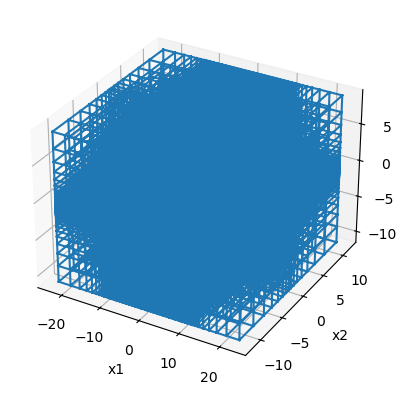

In [5]:
csx = 0.5  # cell size for the horizontal direction
csz = 0.125  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 7  # number of padding cells in the x-direction
npady = 7  # number of padding cells in the y-direction
npadz = 11  # number of padding cells in the z-direction

core_domain_x = np.r_[-11.5, 11.5]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-2.0, 0.0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)
# set the origin
mesh.x0 = np.r_[
    -mesh.h[0].sum() / 2.0, -mesh.h[1].sum() / 2.0, -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

### Set up Inversion Mesh

<Axes: xlabel='x1', ylabel='x2'>

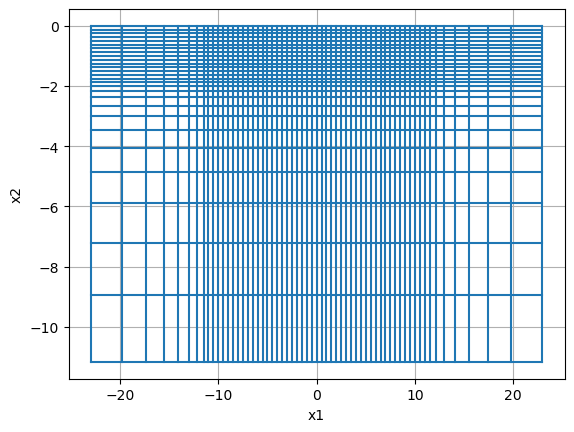

In [6]:
inversion_mesh = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh.x0 = [-inversion_mesh.h[0].sum() / 2.0, -inversion_mesh.h[1].sum()]
inversion_mesh.plot_grid()

### Mappings

In [7]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, sigma_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )  # takes the exponential (log(sigma) --> sigma)
)

### True Model

(-2.0, 0.0)

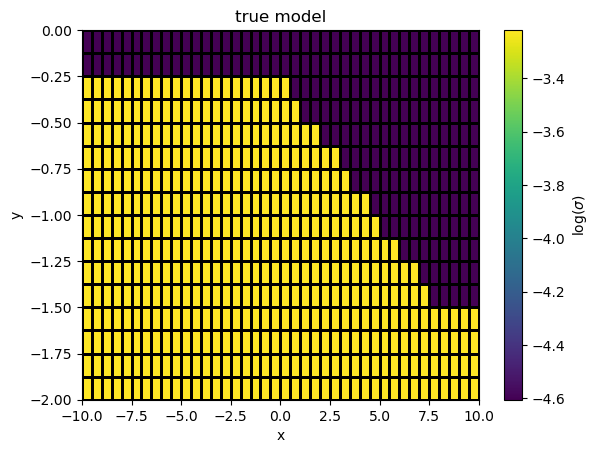

In [8]:
m_true = np.log(sigma_deep) * np.ones(inversion_mesh.nC)
interface_depth = interface(inversion_mesh.gridCC[:, 0])
m_true[inversion_mesh.gridCC[:, 1] > interface_depth] = np.log(sigma_surface)

fig, ax = plt.subplots(1, 1)
cb = plt.colorbar(inversion_mesh.plot_image(m_true, ax=ax, grid=True)[0], ax=ax)
cb.set_label(r"$\log(\sigma)$")
ax.set_title("true model")
ax.set_xlim([-10, 10])
ax.set_ylim([-2, 0])